In [15]:
import torch
torch.cuda.is_available()
print(torch.zeros(1).cuda())

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_sparse import SparseTensor, matmul
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
print(torch_geometric.__version__)

import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

import networkx as nx
from deepsnap.hetero_graph import HeteroGraph
import copy
from copy import deepcopy
import pickle

import deepsnap
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from sklearn.metrics import f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from itertools import combinations
from tqdm.notebook import tqdm

import graph_tool.all as gt
import json
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

tensor([0.], device='cuda:0')
2.1.0
graph-tool version: 2.46


In [16]:
import pickle

with open("../graph_pt_100.pickle", "rb") as f:
    final_graph = pickle.load(f)

In [17]:
print("Number of vertices:", final_graph.num_vertices())
print("Number of edges:", final_graph.num_edges())

Number of vertices: 3644438
Number of edges: 6746550


In [18]:
print('without artists as nodes:')
print("Number of vertices:", final_graph.num_vertices())
print("Number of edges:", final_graph.num_edges())

without artists as nodes:
Number of vertices: 3644438
Number of edges: 6746550


In [19]:
# count_pl = sum(1 for v in final_graph.vertices() if final_graph.vp.pl_type[v] == "playlist")
# print(f'num_playlists: {count_pl}')
# count_tr = sum(1 for v in final_graph.vertices() if final_graph.vp.tr_type[v] == "track")
# print(f'num_tracks: {count_tr}')
# count_ar = sum(1 for v in final_graph.vertices() if final_graph.vp.ar_type[v] == "artist")
# print(f'num_artist: {count_ar}')

In [20]:
print('without artists as nodes:')
count_pl = sum(1 for v in final_graph.vertices() if final_graph.vp.pl_type[v] == "playlist")
print(f'num_playlists: {count_pl}')
count_tr = sum(1 for v in final_graph.vertices() if final_graph.vp.tr_type[v] == "track")
print(f'num_tracks: {count_tr}')
count_ar = sum(1 for v in final_graph.vertices() if final_graph.vp.ar_type[v] == "artist")
print(f'num_artist: {count_ar}')

without artists as nodes:
num_playlists: 102000
num_tracks: 3542438
num_artist: 0


In [21]:
### Removal of duplicate nodes from pickle file


# prop_name = "pl_type"

# # Create a dictionary of property values to vertex IDs
# vertex_dict = {}
# for v in final_graph.vertices():
#     value = final_graph.vp[prop_name][v]
#     if value not in vertex_dict:
#         vertex_dict[value] = [int(v)]
#     else:
#         vertex_dict[value].append(int(v))

# # Remove duplicate nodes
# for value, ids in vertex_dict.items():
#     if len(ids) > 1:
#         print(value,ids)
#         # # Merge the duplicate nodes into the first node
#         # first_id = ids[0]
#         # for other_id in ids[1:]:
#         #     final_graph.vertex(first_id).out_edges()[:] = gt.find_edge(final_graph, final_graph.vertex(first_id), final_graph.vertex(other_id))
#         #     final_graph.vertex(first_id).out_edges()[:] = gt.find_edge(final_graph, final_graph.vertex(other_id), final_graph.vertex(first_id))
#         #     final_graph.remove_vertex(final_graph.vertex(other_id))


# print("Number of vertices:", final_graph.num_vertices())
# print("Number of edges:", final_graph.num_edges())

### Largest component

#### Graph-tool

In [22]:
largest_comp = gt.extract_largest_component(final_graph)
# largest_comp = gt.GraphView(final_graph, vfilt = gt.label_largest_component(final_graph))

In [23]:
print('no artists:')
print("Number of vertices:", largest_comp.num_vertices()) 
print("Number of edges:", largest_comp.num_edges())

no artists:
Number of vertices: 38565
Number of edges: 6746550


In [24]:
print('no artists stats:')
print('----------------')
count_pl = sum(1 for v in largest_comp.vertices() if largest_comp.vp.pl_type[v] == "playlist")
print(f'num_playlists: {count_pl}')
count_tr = sum(1 for v in largest_comp.vertices() if largest_comp.vp.tr_type[v] == "track")
print(f'num_tracks: {count_tr}')
count_ar = sum(1 for v in largest_comp.vertices() if largest_comp.vp.ar_type[v] == "artist")
print(f'num_artist: {count_ar}')

no artists stats:
----------------
num_playlists: 2999
num_tracks: 35566
num_artist: 0


In [25]:
# #### Networkx
# nx_graph = nx.Graph()
# for node in final_graph.vertices():
#     nx_graph.add_node(int(node))
# for edge in final_graph.edges():
#     nx_graph.add_edge(int(edge.source()), int(edge.target()))

# from networkx.algorithms.components import is_connected
# is_connected(nx_graph)

# largest_cc = max(nx.connected_components(nx_graph), key=len)
# nx_largest_comp = nx.Graph(nx_graph.subgraph(largest_cc))
# print('Num nodes:', nx_largest_comp.number_of_nodes(), '. Num edges:', nx_largest_comp.number_of_edges())

### Dataframe generation for EDA

In [26]:
def generate_playlist_df(playlist_id, playlist_json):
    cols = ['plst_id', 'plst_name', 'track_id', 'track_name']
    data_col = []
    plst_name = playlist_json['name']
    
    for track in playlist_json['tracks']:
        track_id = ''.join(track['track_uri'].split(':')[2:])
        data_col.append([f'plst_{playlist_id}', plst_name, track_id, track['track_name']])
        
    plst_df = pd.DataFrame(data=data_col, columns=cols)
    return plst_df

def generate_file_df(start_index, file_json):
    dfs = []
    for i, plst_json in enumerate(file_json['playlists']):
        dfs.append(generate_playlist_df(start_index + i, plst_json))
        
    df_sum = pd.concat(dfs)
    return df_sum

def generate_spotify_df(data_path, start_index=None, end_index=None):
    assert (start_index is None and end_index is None) or \
        (start_index is not None and end_index is not None), 'Set both or none indices.'
    json_names = [f for f in listdir(data_path) if isfile(join(data_path, f)) and '.json' in f]
    
    num_playlists = start_index if start_index is not None else 0
    section = json_names if start_index is None else json_names[start_index:end_index]
    dfs = []
    
    for file_name in tqdm(section, desc='Files processed: ', unit='files', total=len(section)):
        with open(join(data_path, file_name)) as json_file:
            data = json.load(json_file)
            
        dfs.append(generate_file_df(num_playlists, data))
        num_playlists += len(data['playlists'])
        
    df_total = pd.concat(dfs)
    return df_total

# data_path = '../data/'
# df = generate_spotify_df(data_path, 0, 100)

### N-hop neighbourhood

In [27]:
pass

### Deepsnap

In [28]:
g_nx = nx.Graph()

g_nx = nx.Graph()
for v in largest_comp.vertices():
    g_nx.add_node(int(v))

# Add edges to NetworkX graph in batches
batch_size = 100000
edges = [(int(e.source()), int(e.target())) for e in largest_comp.edges()]
num_edges = len(edges)
for i in range(0, num_edges, batch_size):
    batch_edges = edges[i:i+batch_size]
    g_nx.add_edges_from(batch_edges)

        
# Create a DeepSNAP graph from NetworkX graph
ds_graph = Graph(g_nx)

In [30]:
print("Number of nodes:", g_nx.number_of_nodes())
print("Number of edges:", g_nx.number_of_edges())

Number of nodes: 38565
Number of edges: 1813198


In [31]:
print("Number of vertices:", largest_comp.num_vertices()) 
print("Number of edges:", largest_comp.num_edges())

Number of vertices: 38565
Number of edges: 6746550


In [139]:
task = 'link_pred'
dataset = GraphDataset([ds_graph], task=task, edge_train_mode='disjoint')

dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

# dataset_train[0].to('cuda')
# dataset_val[0].to('cuda')
# dataset_test[0].to('cuda')

# dataset_train.to('cuda:0')
# dataset_val.to('cuda:0')
# dataset_test.to('cuda:0')

print(type(dataset_train))
print(dataset_train[0])
print(type(dataset_train[0]))

num_train_edges = dataset_train[0].edge_label_index.shape[1]
num_val_edges = dataset_val[0].edge_label_index.shape[1]
num_test_edges = dataset_test[0].edge_label_index.shape[1]

print("Train set has {} supervision (positive) edges".format(num_train_edges // 2))
print("Validation set has {} supervision (positive) edges".format(num_val_edges // 2))
print("Test set has {} supervision (positive) edges".format(num_test_edges // 2))

print("Train set has {} message passing edges".format(dataset_train[0].edge_index.shape[1]))
print("Validation set has {} message passing edges".format(dataset_val[0].edge_index.shape[1]))
print("Test set has {} message passing edges".format(dataset_test[0].edge_index.shape[1]))

GraphDataset(1)
<class 'deepsnap.dataset.GraphDataset'>
Graph(G=[], edge_index=[2, 2320892], edge_label=[1160448], edge_label_index=[2, 1160448], negative_label_val=[1], node_label_index=[38565])
<class 'deepsnap.graph.Graph'>
Train set has 580224 supervision (positive) edges
Validation set has 362638 supervision (positive) edges
Test set has 362642 supervision (positive) edges
Train set has 2320892 message passing edges
Validation set has 2901116 message passing edges
Test set has 3263754 message passing edges


In [ ]:
# pickle.dump(dataset_train, open('./graphs/train.graph', 'wb'))
# pickle.dump(dataset_val, open('./graphs/val.graph', 'wb'))
# pickle.dump(dataset_test, open('./graphs/test.graph', 'wb'))

In [ ]:
# dataset_train = pickle.load(open('./graphs/train.graph', 'rb'))
# dataset_val = pickle.load(open('./graphs/val.graph', 'rb'))
# dataset_test = pickle.load(open('./graphs/test.graph', 'rb'))

In [140]:
class LightGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

    def forward(self, x, edge_index, size = None):
        out = self.propagate(edge_index, x=(x, x))
        return out

    def message(self, x_j):
        out = x_j
        return out

    def aggregate(self, inputs, index, dim_size = None):
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')
        return out

In [141]:
class LightGCN(torch.nn.Module):
    def __init__(self, train_data, num_layers, emb_size=16, initialize_with_words=False):
        super(LightGCN, self).__init__()
        self.convs = nn.ModuleList()
        assert (num_layers >= 1), 'Number of layers is not >=1'
        for l in range(num_layers):
            self.convs.append(LightGCNConv(input_dim, input_dim))

        # Initialize using custom embeddings if provided
        num_nodes = train_data.node_label_index.size()[0]
        self.embeddings = nn.Embedding(num_nodes, emb_size)
        if initialize_with_words:
            self.embeddings.weight.data.copy_(train_datanode_features)
        
        self.loss_fn = nn.BCELoss()
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.num_modes = num_nodes

    def forward(self, data):
        edge_index, edge_label_index, node_label_index = data.edge_index, data.edge_label_index, data.node_label_index
        layer_embeddings = []
        
        x = self.embeddings(node_label_index)
        mean_layer = x

        # We take an average of ever layer's node embeddings
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            mean_layer += x

        mean_layer /= 4

        # Prediction head is simply dot product
        nodes_first = torch.index_select(x, 0, edge_label_index[0,:].long())
        nodes_second = torch.index_select(x, 0, edge_label_index[1,:].long())

        # Since we don't want a rank output, we create a sigmoid of the dot product
        out = torch.sum(nodes_first * nodes_second, dim=-1) # FOR RANKING
        pred = torch.sigmoid(out)

        return torch.flatten(pred)

    def loss(self, pred, label):
        return self.loss_fn(pred, label)

In [142]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
print(type(dataset_train))

<class 'deepsnap.dataset.GraphDataset'>


In [145]:
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' : 3,
    'emb_size' : 32,
    'epochs' : 1,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 300
}

datasets = {
    'train': dataset_train[0],
    'val': dataset_val[0],
    'test': dataset_test[0]
}
            
input_dim = datasets['train'].num_node_features
print(input_dim, args)

0 {'device': 'cuda', 'num_layers': 3, 'emb_size': 32, 'epochs': 300, 'weight_decay': 1e-05, 'lr': 0.01}


In [132]:
# datasets['train'].to(args['device'])
# datasets['val'].to(args['device'])
# datasets['test'].to(args['device'])

In [146]:
losses = []

def train(model, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args['epochs'] + 1):
        datasets['train'].to(args["device"])
        model.train()
        optimizer.zero_grad()
        pred = model(datasets['train'])
        loss = model.loss(pred, datasets['train'].edge_label.type(pred.dtype))

        loss.backward()
        optimizer.step()

        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {:.5f}, Val Loss: {:.5f}'
        score_train, train_loss = test(model, 'train', args)
        score_val, val_loss = test(model, 'val', args)
        score_test, test_loss = test(model, 'test', args)

        losses.append((train_loss, val_loss))

        print(log.format(epoch, score_train, score_val, score_test, train_loss, val_loss))
        if val_max < score_val:
            val_max = score_val
            best_model = copy.deepcopy(model)

    return best_model

def test(model, mode, args):
    model.eval()
    score = 0
    loss_score = 0

    data = datasets[mode]
    data.to(args["device"])

    pred = model(data)
    loss = model.loss(pred, data.edge_label.type(pred.dtype))
    score += roc_auc_score(data.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    loss_score += loss.item()

    return score, loss_score

In [157]:
model = LightGCN(datasets['train'], args['num_layers'], emb_size=args['emb_size']).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

best_model = train(model, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Train Loss: {:.5f}, Val Loss: {:.5f}, Test Loss: {:.5f}"
best_train_roc, train_loss = test(best_model, 'train', args)
best_val_roc, val_loss = test(best_model, 'val', args)
best_test_roc, test_loss = test(best_model, 'test', args)
print(log.format(best_train_roc, best_val_roc, best_test_roc, train_loss, val_loss, test_loss))

Epoch: 001, Train: 0.5244, Val: 0.5228, Test: 0.5232, Loss: 0.69823, Val Loss: 0.69841
Epoch: 002, Train: 0.5728, Val: 0.5719, Test: 0.5720, Loss: 0.69597, Val Loss: 0.69614
Epoch: 003, Train: 0.6084, Val: 0.6072, Test: 0.6074, Loss: 0.69435, Val Loss: 0.69451
Epoch: 004, Train: 0.6348, Val: 0.6330, Test: 0.6332, Loss: 0.69321, Val Loss: 0.69335
Epoch: 005, Train: 0.6550, Val: 0.6530, Test: 0.6530, Loss: 0.69241, Val Loss: 0.69254
Epoch: 006, Train: 0.6703, Val: 0.6683, Test: 0.6682, Loss: 0.69184, Val Loss: 0.69197
Epoch: 007, Train: 0.6813, Val: 0.6795, Test: 0.6793, Loss: 0.69142, Val Loss: 0.69155
Epoch: 008, Train: 0.6900, Val: 0.6882, Test: 0.6881, Loss: 0.69109, Val Loss: 0.69121
Epoch: 009, Train: 0.6978, Val: 0.6960, Test: 0.6961, Loss: 0.69080, Val Loss: 0.69091
Epoch: 010, Train: 0.7052, Val: 0.7036, Test: 0.7038, Loss: 0.69051, Val Loss: 0.69063
Epoch: 011, Train: 0.7128, Val: 0.7112, Test: 0.7115, Loss: 0.69023, Val Loss: 0.69034
Epoch: 012, Train: 0.7204, Val: 0.7187, Tes

In [159]:
data = datasets['test']
pred = model(data)


In [175]:
data

Graph(G=[], edge_index=[2, 3263754], edge_label=[725284], edge_label_index=[2, 725284], negative_label_val=[1], node_label_index=[38565])

In [176]:
data.edge_index

tensor([[    0,     0,     0,  ..., 36464, 37910, 35325],
        [ 1171,  1105,  1187,  ...,   999,   999,   999]], device='cuda:0')

In [177]:
data.edge_label

tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')

In [178]:
data.edge_label_index

tensor([[  366,   242,   690,  ...,  5703, 10719, 27465],
        [17083, 13053, 28496,  ..., 19909, 17538,  5413]], device='cuda:0')

In [172]:
data

Graph(G=[], edge_index=[2, 3263754], edge_label=[725284], edge_label_index=[2, 725284], negative_label_val=[1], node_label_index=[38565])

In [171]:
type(data)

deepsnap.graph.Graph

In [168]:
data.edge_label_index

tensor([[  366,   242,   690,  ...,  5703, 10719, 27465],
        [17083, 13053, 28496,  ..., 19909, 17538,  5413]], device='cuda:0')

In [153]:
def plot_learning_curve(losses, title):
    train_loss, val_loss = zip(*losses)
    steps = list(range(1, len(train_loss) + 1))
    
    min_val_loss = np.round(np.min(val_loss), 3)
    
    plt.figure(figsize=(16, 6))
    plt.plot(steps, train_loss, '-r', label='Training Loss')
    plt.plot(steps, val_loss, '-b', label='Validation Loss')
    plt.hlines(min_val_loss, 1, 300, colors='k', linestyles='dotted', label='Min Validation Loss: {}'.format(min_val_loss))

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim((0.58, 0.71))
    plt.title(title)
    plt.legend(loc='upper right')
    plt.title(title)

    return plt

<module 'matplotlib.pyplot' from '/home/asd27/.conda/envs/cudatorch/lib/python3.11/site-packages/matplotlib/pyplot.py'>

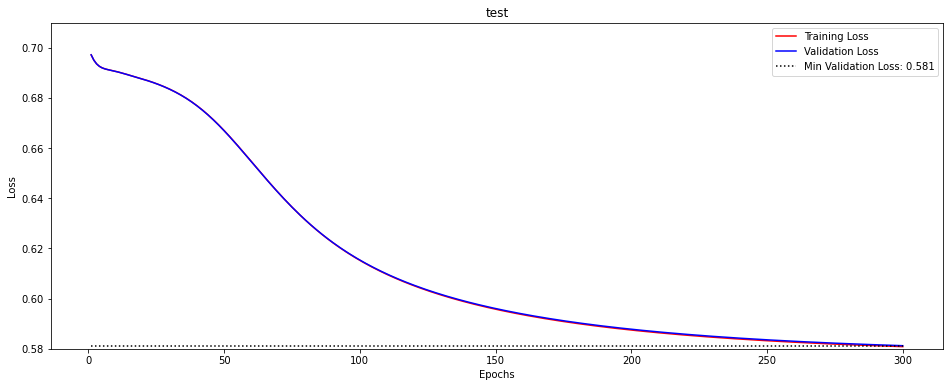

In [154]:
plot_learning_curve(losses, 'test')